# Ligand ADMET and Potency (Property Prediction)

The [ADMET](https://polarishub.io/competitions/asap-discovery/antiviral-admet-2025) and [Potency](https://polarishub.io/competitions/asap-discovery/antiviral-potency-2025) Challenge of the [ASAP Discovery competition](https://polarishub.io/blog/antiviral-competition) take the shape of a property prediction task. Given the SMILES (or, to be more precise, the CXSMILES) of a molecule, you are asked to predict the numerical properties of said molecule. This is a relatively straight-forward application of ML and this notebook will quickly get you up and running!

To begin with, choose one of the two challenges! The code will look the same for both. 

As suggested in the logs, we'll cache the dataset. Note that this is not strictly necessary, but it does speed up later steps.

In [1]:
import pandas as pd

potency_df = pd.read_csv("antiviral_potency_2025.csv")

In [2]:
potency_df

,CXSMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro)
0,COC[C@]1(C)C(=O)N(C2=CN=CC3=CC=CC=C23)C(=O)N1C...,ASAP-0000141,Train,4.19,NaN
1,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000142,Train,4.92,5.29
2,CNC(=O)CN1C[C@]2(C[C@H](C)N(C3=CN=CC=C3C3CC3)C...,ASAP-0000143,Train,4.73,NaN
3,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000144,Train,4.90,6.11
4,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000145,Train,4.81,5.62
...,...,...,...,...,...
1323,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032561,Test,4.54,4.20
1324,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032562,Test,4.42,NaN
1325,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]2CCCC[C@@H]...,ASAP-0032572,Test,4.84,5.18
1326,COC1=CC=CC=C1[C@H]1C[C@H](C)CCN1C(=O)CC1=CN=CC...,ASAP-0032604,Test,5.53,5.59


In [3]:
train_df = potency_df[potency_df['Set'] == 'Train'].rename(columns={'CXSMILES': 'SMILES'})

In [4]:
test_sars_df = (
    potency_df[
        (potency_df['Set'] == 'Test') &
        (potency_df['pIC50 (SARS-CoV-2 Mpro)'].notna())
    ]
    .rename(columns={'CXSMILES': 'SMILES'})
)

In [5]:
test_sars_df

,SMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro)
1031,C=CC(=O)NC1=CC=CC(N(CC2=CC=CC(Cl)=C2)C(=O)CC2=...,ASAP-0000175,Test,5.52,5.57
1033,CNC(=O)CN1C[C@]2(CCN(C3=CN=CC4=CC=C(OC[C@H](O)...,ASAP-0000528,Test,5.80,7.44
1034,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,ASAP-0000541,Test,5.81,6.48
1035,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,ASAP-0000733,Test,6.69,7.87
1036,CNC(=O)CN1C[C@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C[...,ASAP-0000738,Test,5.98,7.60
...,...,...,...,...,...
1322,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032560,Test,4.33,4.02
1323,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032561,Test,4.54,4.20
1325,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]2CCCC[C@@H]...,ASAP-0032572,Test,4.84,5.18
1326,COC1=CC=CC=C1[C@H]1C[C@H](C)CCN1C(=O)CC1=CN=CC...,ASAP-0032604,Test,5.53,5.59


In [6]:
train_df.to_csv("potency_training_unblinded.csv")

### Raw data dump
We've decided to sacrifice the completeness of the scientific data to improve its ease of use. For those that are interested, you can also access the raw data dump that this dataset has been created from.

## Build a model
Next, we'll train a simple baseline model using scikit-learn. 

You'll notice that the challenge has multiple targets.

In [7]:
from qsprpred.data import QSPRDataset
from sklearn.impute import SimpleImputer

In [8]:
sars_props = [
    {"name": "pIC50 (SARS-CoV-2 Mpro)", "task": "REGRESSION"},]

## MERS Model Generation

Create for PCA QSPRDataset of test and training with known Descriptors, which were previously calculated

In [9]:
from qsprpred.data import QSPRDataset
from sklearn.impute import SimpleImputer

dataset_test_sars = QSPRDataset(
    name="MultiTaskTutorialDataset",
    target_props=sars_props,
    df=test_sars_df,
    store_dir="sars_output_adjusted_22/data_test_rf",
    overwrite=True
)


dataset_test_sars.getDF()

,SMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro),QSPRID,pIC50 (SARS-CoV-2 Mpro)_original
QSPRID,,,,,,,
MultiTaskTutorialDataset_000,C=CC(=O)NC1=CC=CC(N(CC2=CC=CC(Cl)=C2)C(=O)CC2=...,ASAP-0000175,Test,5.52,5.57,MultiTaskTutorialDataset_000,5.57
MultiTaskTutorialDataset_001,CNC(=O)CN1C[C@]2(CCN(C3=CN=CC4=CC=C(OC[C@H](O)...,ASAP-0000528,Test,5.80,7.44,MultiTaskTutorialDataset_001,7.44
MultiTaskTutorialDataset_002,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,ASAP-0000541,Test,5.81,6.48,MultiTaskTutorialDataset_002,6.48
MultiTaskTutorialDataset_003,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,ASAP-0000733,Test,6.69,7.87,MultiTaskTutorialDataset_003,7.87
MultiTaskTutorialDataset_004,CNC(=O)CN1C[C@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C[...,ASAP-0000738,Test,5.98,7.60,MultiTaskTutorialDataset_004,7.60
...,...,...,...,...,...,...,...
MultiTaskTutorialDataset_258,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032560,Test,4.33,4.02,MultiTaskTutorialDataset_258,4.02
MultiTaskTutorialDataset_259,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032561,Test,4.54,4.20,MultiTaskTutorialDataset_259,4.20
MultiTaskTutorialDataset_260,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]2CCCC[C@@H]...,ASAP-0032572,Test,4.84,5.18,MultiTaskTutorialDataset_260,5.18


In [10]:
from qsprpred.data import RandomSplit, BootstrapSplit, ScaffoldSplit, ClusterSplit
from qsprpred.data.descriptors.fingerprints import MorganFP, RDKitFP
from qsprpred.data.processing.feature_filters import LowVarianceFilter
from sklearn.preprocessing import StandardScaler

# Specifiy random split for creating the train (80%) and test set (20%)
rand_split = ClusterSplit(test_fraction=0.2, dataset=dataset_test_sars)
# rand_split = RandomSplit(test_fraction=0.15, dataset=dataset_mers)

# calculate compound features and split dataset into train and test
dataset_test_sars.prepareDataset(
    split=rand_split,
    feature_calculators=[MorganFP(radius=3, nBits=1024), RDKitFP(maxPath=4, nBits=256)],
    recalculate_features=True,
)

print(f"Number of samples train set: {len(dataset_test_sars.y)}")
print(f"Number of samples test set: {len(dataset_test_sars.y_ind)}")

print(type(dataset_test_sars.X))
print(dataset_test_sars.X.shape)
print(dataset_test_sars.X_ind.shape)


dataset_test_sars.save()

Number of samples train set: 211
Number of samples test set: 52
<class 'pandas.core.frame.DataFrame'>
(211, 1280)
(52, 1280)


In [11]:
from qsprpred.data import QSPRDataset
from sklearn.impute import SimpleImputer

dataset_sars = QSPRDataset(
    name="MultiTaskTutorialDataset",
    target_props=sars_props,
    df=train_df,
    store_dir="sars_output_adjusted_22/data_rf",
    overwrite=True
)


dataset_sars.getDF()

,SMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro),QSPRID,pIC50 (SARS-CoV-2 Mpro)_original
QSPRID,,,,,,,
MultiTaskTutorialDataset_0001,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000142,Train,4.92,5.29,MultiTaskTutorialDataset_0001,5.29
MultiTaskTutorialDataset_0003,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000144,Train,4.90,6.11,MultiTaskTutorialDataset_0003,6.11
MultiTaskTutorialDataset_0004,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000145,Train,4.81,5.62,MultiTaskTutorialDataset_0004,5.62
MultiTaskTutorialDataset_0005,C=C(CN(C(=O)C1CCOC2=C1C=C(Cl)C=C2)C1=CN=CC2=CC...,ASAP-0000146,Train,4.88,6.45,MultiTaskTutorialDataset_0005,6.45
MultiTaskTutorialDataset_0006,C=C(CN(C(=O)C1CCOC2=C1C=C(Cl)C=C2)C1=CN=CC2=CC...,ASAP-0000147,Train,4.81,5.56,MultiTaskTutorialDataset_0006,5.56
...,...,...,...,...,...,...,...
MultiTaskTutorialDataset_1021,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC([C@H]2CCOC2)CC1...,ASAP-0031882,Train,4.27,4.68,MultiTaskTutorialDataset_1021,4.68
MultiTaskTutorialDataset_1022,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC2(CC2)C1,ASAP-0031887,Train,4.11,4.41,MultiTaskTutorialDataset_1022,4.41
MultiTaskTutorialDataset_1026,CNS(=O)(=O)OCC(=O)N1CCN(CC2=CC=CC(Cl)=C2)[C@H]...,ASAP-0031916,Train,5.57,6.38,MultiTaskTutorialDataset_1026,6.38


In [12]:
from qsprpred.data import RandomSplit, BootstrapSplit, ScaffoldSplit, ClusterSplit
from qsprpred.data.descriptors.fingerprints import MorganFP, RDKitFP
from qsprpred.data.processing.feature_filters import LowVarianceFilter
from sklearn.preprocessing import StandardScaler

# Specifiy random split for creating the train (80%) and test set (20%)
rand_split = ClusterSplit(test_fraction=0.2, dataset=dataset_sars)
# rand_split = RandomSplit(test_fraction=0.15, dataset=dataset_mers)

# calculate compound features and split dataset into train and test
dataset_sars.prepareDataset(
    split=rand_split,
    feature_calculators=[MorganFP(radius=3, nBits=1024), RDKitFP(maxPath=4, nBits=256)],
    recalculate_features=True,
)

print(f"Number of samples train set: {len(dataset_sars.y)}")
print(f"Number of samples test set: {len(dataset_sars.y_ind)}")

print(type(dataset_sars.X))
print(dataset_sars.X.shape)
print(dataset_sars.X_ind.shape)


dataset_sars.save()

Number of samples train set: 673
Number of samples test set: 169
<class 'pandas.core.frame.DataFrame'>
(673, 1280)
(169, 1280)


In [13]:
from qsprpred.data import RandomSplit, BootstrapSplit, ScaffoldSplit, ClusterSplit
from qsprpred.data.descriptors.fingerprints import MorganFP, RDKitFP
from qsprpred.data.processing.feature_filters import LowVarianceFilter
from sklearn.preprocessing import StandardScaler

# Specifiy random split for creating the train (80%) and test set (20%)
rand_split = ClusterSplit(test_fraction=0.2, dataset=dataset_sars)
# rand_split = RandomSplit(test_fraction=0.15, dataset=dataset_mers)

# calculate compound features and split dataset into train and test
dataset_sars.prepareDataset(
    split=rand_split,
    feature_calculators=[MorganFP(radius=3, nBits=1024), RDKitFP(maxPath=4, nBits=256)],
    recalculate_features=True,
)

print(f"Number of samples train set: {len(dataset_sars.y)}")
print(f"Number of samples test set: {len(dataset_sars.y_ind)}")

print(type(dataset_sars.X))
print(dataset_sars.X.shape)
print(dataset_sars.X_ind.shape)


dataset_sars.save()

Number of samples train set: 673
Number of samples test set: 169
<class 'pandas.core.frame.DataFrame'>
(673, 1280)
(169, 1280)


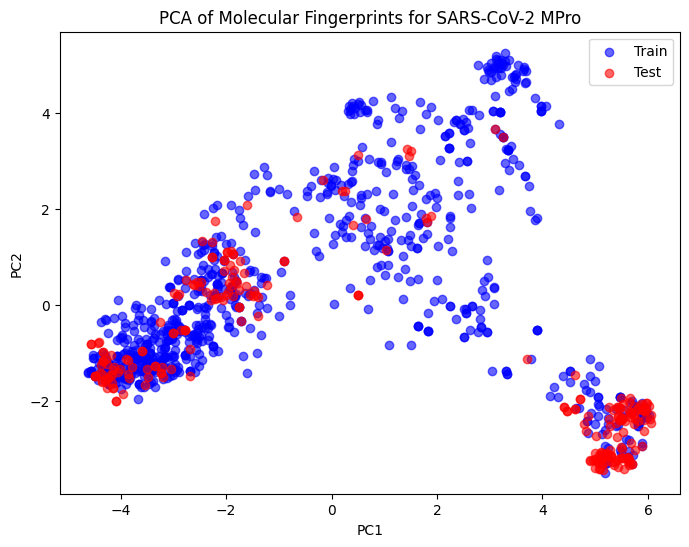

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Combine train and test for X into one "Train"
X_all_train = np.vstack([dataset_sars.X, dataset_sars.X_ind])

# Combine train and test for Y into one "Test"
X_all_test = np.vstack([dataset_test_sars.X, dataset_test_sars.X_ind])

# Fit PCA on combined space so both sets are projected in same PC space
X_combined = np.vstack([X_all_train, X_all_test])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Separate transformed "train" and "test"
X_train_pca = X_pca[:len(X_all_train)]
X_test_pca = X_pca[len(X_all_train):]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
            alpha=0.6, label='Train', c='blue')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
            alpha=0.6, label='Test', c='red')

plt.xlabel(f"PC1")
plt.ylabel(f"PC2")
plt.title("PCA of Molecular Fingerprints for SARS-CoV-2 MPro")
plt.legend()

plt.savefig("PCA_train_test_sars_rf.png", dpi=300)
plt.show()


In [15]:
from qsprpred.data import RandomSplit, BootstrapSplit, ScaffoldSplit, ClusterSplit
from qsprpred.data.descriptors.fingerprints import MorganFP, RDKitFP
from qsprpred.data.processing.feature_filters import LowVarianceFilter
from sklearn.preprocessing import StandardScaler

# Specifiy random split for creating the train (80%) and test set (20%)
rand_split = ClusterSplit(test_fraction=0.2, dataset=dataset_sars)
# rand_split = RandomSplit(test_fraction=0.15, dataset=dataset_mers)

# calculate compound features and split dataset into train and test
dataset_sars.prepareDataset(
    split=rand_split,
    feature_calculators=[MorganFP(radius=3, nBits=1024), RDKitFP(maxPath=4, nBits=256)],
    recalculate_features=True,
    feature_filters=[LowVarianceFilter(0.001)],
    feature_standardizer=StandardScaler()
)

print(f"Number of samples train set: {len(dataset_sars.y)}")
print(f"Number of samples test set: {len(dataset_sars.y_ind)}")

print(type(dataset_sars.X))
print(dataset_sars.X.shape)
print(dataset_sars.X_ind.shape)


dataset_sars.save()

Number of samples train set: 673
Number of samples test set: 169
<class 'pandas.core.frame.DataFrame'>
(673, 1245)
(169, 1245)


In [16]:
from qsprpred.models import SklearnModel
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from qsprpred.models import CrossValAssessor, TestSetAssessor

os.makedirs("class_models/RF_models_clust_sars_test", exist_ok=True)

# This is an SKlearn model, so we will initialize it with the SklearnModel class
model_sars = SklearnModel(
    base_dir="class_models/RF_models_clust_sars_test",
    alg=RandomForestRegressor,
    name="RFMorgan_clustsplit"
)

import numpy as np
from qsprpred.models import GridSearchOptimization, CrossValAssessor

In [17]:
from qsprpred.models import OptunaOptimization, TestSetAssessor
from sklearn.model_selection import KFold

# Note the specification of the hyperparameter types as first item in the list
search_space = {
    "n_estimators": ["int", 10, 300],
    "max_depth": ["int", 1, 50],
    "min_samples_split": ["int", 2, 20],
    "min_samples_leaf": ["int", 1, 20],
    "max_features": ["categorical", ["sqrt", "log2", None]],
}

# Optuna gridsearcher with the TestSetAssessor
gridsearcher = OptunaOptimization(
    n_trials=500,
    param_grid=search_space,
    model_assessor=TestSetAssessor(scoring='neg_mean_absolute_error'),
)
gridsearcher.optimize(model_sars, dataset_sars)

[I 2025-08-13 10:16:17,994] A new study created in memory with name: no-name-339fe6eb-9f5f-408e-9353-71cefd763977
[I 2025-08-13 10:16:19,001] Trial 0 finished with value: -0.7401679662478924 and parameters: {'n_estimators': 215, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 0 with value: -0.7401679662478924.
[I 2025-08-13 10:16:19,082] Trial 1 finished with value: -0.6761047860493977 and parameters: {'n_estimators': 207, 'max_depth': 31, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: -0.6761047860493977.
[I 2025-08-13 10:16:20,902] Trial 2 finished with value: -0.7253141038419312 and parameters: {'n_estimators': 200, 'max_depth': 34, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: -0.6761047860493977.
[I 2025-08-13 10:16:21,090] Trial 3 finished with value: -0.7522100153610018 and parameters: {'n_estimators': 37, 'max_depth': 3

{'n_estimators': 18,
 'max_depth': 31,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_features': 'sqrt'}

{'max_depth': 11,
 'gamma': 0,
 'max_delta_step': 14,
 'min_child_weight': 14,
 'learning_rate': 0.10433524150608854,
 'subsample': 0.38831917232016605,
 'n_estimators': 101}

In [19]:
sd

NameError: name 'sd' is not defined

In [20]:
# We can now assess the model performance on the training set using cross validation
from sklearn.metrics import mean_squared_error
import sklearn
from sklearn import metrics

print(sklearn.metrics.get_scorer_names())

CrossValAssessor(
    scoring="neg_mean_absolute_error",
    split=BootstrapSplit(split=ClusterSplit(dataset_sars), n_bootstraps=100)
)(model_sars, dataset_sars)

# and on the test set
TestSetAssessor("neg_mean_absolute_error")(model_sars, dataset_sars)


['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'neg_root_mean_squared_log_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc',

array([-0.61800179])

In [21]:
# Finally, we need to fit the model on the complete dataset if we want to use it further
model_sars.fitDataset(dataset_sars)

# and save the model
_ = model_sars.save()

RFMorgan_clustsplit


/home/valerij/miniconda3/envs/pol/lib/python3.12/site-packages/qsprpred/plotting/regression.py:99: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


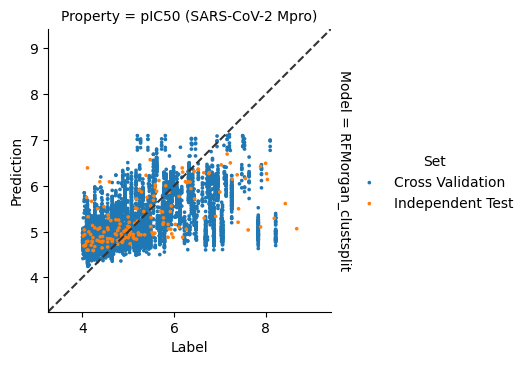

                   Model              Fold                 Property        R2  \
0    RFMorgan_clustsplit               0.0  pIC50 (SARS-CoV-2 Mpro)  0.126943   
1    RFMorgan_clustsplit               1.0  pIC50 (SARS-CoV-2 Mpro)  0.064141   
2    RFMorgan_clustsplit               2.0  pIC50 (SARS-CoV-2 Mpro)  0.162515   
3    RFMorgan_clustsplit               3.0  pIC50 (SARS-CoV-2 Mpro)  0.274138   
4    RFMorgan_clustsplit               4.0  pIC50 (SARS-CoV-2 Mpro)  0.496993   
..                   ...               ...                      ...       ...   
96   RFMorgan_clustsplit              96.0  pIC50 (SARS-CoV-2 Mpro)  0.019018   
97   RFMorgan_clustsplit              97.0  pIC50 (SARS-CoV-2 Mpro)  0.129058   
98   RFMorgan_clustsplit              98.0  pIC50 (SARS-CoV-2 Mpro)  0.242625   
99   RFMorgan_clustsplit              99.0  pIC50 (SARS-CoV-2 Mpro)  0.179972   
100  RFMorgan_clustsplit  Independent Test  pIC50 (SARS-CoV-2 Mpro)  0.337007   

         RMSE              

<Figure size 640x480 with 0 Axes>

In [22]:
from qsprpred.plotting.regression import CorrelationPlot

# Instantiate with a list of models
plotter = CorrelationPlot(models=[model_sars])

# Create and optionally save/show the plot
g, summary_df = plotter.make(save=True, show=True, out_path="sars_cor_plot_rf.png")

# summary_df contains metrics like R2, RMSE per model, fold, property
print(summary_df)

In [23]:
with open("sars_test.smi", "w") as f:
    for smi in test_sars_df["SMILES"]:
        f.write(f"{smi}\n")

In [24]:
from rdkit import Chem
from rdkit.Chem import MolStandardize

def read_smi_file(file_path):
    smiles_list = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Skip comment lines and empty lines
                if line.strip() and not line.startswith('#'):
                    # SMILES strings are typically separated by whitespace or tab
                    smiles = line.split()[0]
                    smiles_list.append(smiles)
    except FileNotFoundError:
        print("File not found.")
    return smiles_list

# Example usage to read the standardized SMILES file and create a list
file_path = 'sars_test.smi'
smiles_list = read_smi_file(file_path)
print("SMILES in the file:")
print(len(smiles_list))

SMILES in the file:
263


In [25]:
well = model_sars.predictMols(smiles_list)

In [26]:
print(well)

[[5.31670621]
 [6.23408614]
 [5.81276174]
 [6.5890921 ]
 [6.24786322]
 [6.53414805]
 [6.4894332 ]
 [6.14880763]
 [6.35279415]
 [5.48279393]
 [6.77335541]
 [6.48541429]
 [6.559869  ]
 [6.62389489]
 [6.56487   ]
 [6.57124391]
 [6.50337355]
 [5.02758074]
 [6.61204688]
 [6.51180984]
 [6.82681536]
 [6.39065687]
 [7.27295395]
 [6.23852216]
 [6.77944343]
 [6.67505296]
 [7.10717489]
 [6.41176164]
 [5.54714633]
 [7.15228092]
 [7.02079196]
 [6.29442616]
 [6.54256667]
 [6.42545548]
 [6.73478423]
 [7.28884831]
 [7.24099065]
 [6.62331098]
 [6.5549311 ]
 [6.38535774]
 [6.714317  ]
 [5.76791258]
 [5.76791258]
 [5.89482848]
 [5.89482848]
 [5.85122268]
 [5.85122268]
 [5.93777823]
 [5.93777823]
 [6.73352214]
 [6.48271109]
 [6.80491791]
 [6.48653187]
 [6.40007341]
 [6.39552068]
 [6.61697143]
 [7.11444957]
 [6.51282333]
 [6.75470365]
 [6.2878035 ]
 [6.28531896]
 [6.35454215]
 [6.47649779]
 [7.13852364]
 [7.11444957]
 [7.0365102 ]
 [7.32034753]
 [7.12793605]
 [6.44792076]
 [6.46507112]
 [7.07593348]
 [7.16

In [27]:
min_length = min(len(smiles_list), len(well))
values = [val[0] for val in well[:min_length]] 

In [28]:
print(values)

[5.316706209890613, 6.234086140347773, 5.812761742318759, 6.589092102821163, 6.247863223766303, 6.534148045944614, 6.489433197294717, 6.1488076253648645, 6.352794148591967, 5.482793931331921, 6.773355413584474, 6.485414287352368, 6.55986899658649, 6.623894890628852, 6.564870002933085, 6.571243912949794, 6.503373548407217, 5.02758073771732, 6.612046882855706, 6.51180983924233, 6.826815359319617, 6.390656871565542, 7.272953948330173, 6.238522157423473, 6.779443434152993, 6.675052956645987, 7.107174886705524, 6.4117616352658935, 5.54714633417265, 7.152280916206162, 7.020791960354459, 6.294426164139294, 6.5425666701003395, 6.425455475195027, 6.7347842274827565, 7.288848311682871, 7.24099065009972, 6.623310980439551, 6.554931095663833, 6.385357739210681, 6.71431700026553, 5.767912577391743, 5.767912577391743, 5.8948284761262695, 5.8948284761262695, 5.8512226791645645, 5.8512226791645645, 5.93777823472012, 5.93777823472012, 6.733522143276399, 6.482711090833639, 6.80491791145158, 6.4865318715

In [29]:
import csv
# Write to CSV file
with open("sars_prediction_final_rf.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["SMILES", "SARS"])
    for smiles, value in zip(smiles_list, values):
        writer.writerow([smiles, value])

print("CSV file created successfully!")

CSV file created successfully!


In [30]:
pd.read_csv("sars_prediction_final_rf.csv")

,SMILES,SARS
0,C=CC(=O)Nc1cccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3c...,5.316706
1,CNC(=O)CN1C[C@]2(CCN(c3cncc4ccc(OC[C@H](O)CN(C...,6.234086
2,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,5.812762
3,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,6.589092
4,CNC(=O)CN1C[C@]2(C(=O)N(c3cncc4ccccc34)C[C@H]2...,6.247863
...,...,...
258,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1,4.507152
259,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1,4.507152
260,O=C(Cc1cncc2ccccc12)N1CCC[C@H]2CCCC[C@@H]21,5.041484
261,COc1ccccc1[C@H]1C[C@H](C)CCN1C(=O)Cc1cncc2ccccc12,5.723949


In [31]:
test_sars_df["predicted SARS"] = values

In [32]:
test_sars_df

,SMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro),QSPRID,pIC50 (SARS-CoV-2 Mpro)_original,Split_IsTrain,predicted SARS
QSPRID,,,,,,,,,
MultiTaskTutorialDataset_000,C=CC(=O)Nc1cccc(N(Cc2cccc(Cl)c2)C(=O)Cc2cncc3c...,ASAP-0000175,Test,5.52,5.57,MultiTaskTutorialDataset_000,5.57,True,5.316706
MultiTaskTutorialDataset_001,CNC(=O)CN1C[C@]2(CCN(c3cncc4ccc(OC[C@H](O)CN(C...,ASAP-0000528,Test,5.80,7.44,MultiTaskTutorialDataset_001,7.44,False,6.234086
MultiTaskTutorialDataset_002,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,ASAP-0000541,Test,5.81,6.48,MultiTaskTutorialDataset_002,6.48,True,5.812762
MultiTaskTutorialDataset_003,CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H...,ASAP-0000733,Test,6.69,7.87,MultiTaskTutorialDataset_003,7.87,True,6.589092
MultiTaskTutorialDataset_004,CNC(=O)CN1C[C@]2(C(=O)N(c3cncc4ccccc34)C[C@H]2...,ASAP-0000738,Test,5.98,7.60,MultiTaskTutorialDataset_004,7.60,True,6.247863
...,...,...,...,...,...,...,...,...,...
MultiTaskTutorialDataset_258,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1,ASAP-0032560,Test,4.33,4.02,MultiTaskTutorialDataset_258,4.02,True,4.507152
MultiTaskTutorialDataset_259,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1,ASAP-0032561,Test,4.54,4.20,MultiTaskTutorialDataset_259,4.20,True,4.507152
MultiTaskTutorialDataset_260,O=C(Cc1cncc2ccccc12)N1CCC[C@H]2CCCC[C@@H]21,ASAP-0032572,Test,4.84,5.18,MultiTaskTutorialDataset_260,5.18,False,5.041484


In [33]:
test_sars_df.to_csv("sars_predicted_true_rf.csv")

The End.